In [1]:
!/opt/bin/nvidia-smi

Wed Mar 16 05:49:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project')
print(os.getcwd())

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.layers import Dense, Dropout, LSTM,Reshape, GRU,Conv1D, Conv2D,Flatten,Permute, multiply,BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply, ReLU
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import rmsprop_v2
from keras.optimizers import adam_v2
from keras import regularizers
from keras.callbacks import Callback

In [5]:
import matplotlib.pyplot as plt

def plot_func(y_list, x_list, label_list, title):
  plt.figure()
  for i in range(len(x_list)):
    x = x_list[i]
    y = y_list[i]
    label = label_list[i]
    plt.plot(x, y, label=label)
  plt.title(title)
  plt.legend()
  plt.savefig('pics/'+title+'.png')
  plt.show()
  return


# ['loss', 'mse', 'val_loss', 'val_mse', 'lr']

def plot_all(hist, name):
  info_hist = hist.history
  y = np.array(hist.epoch) + 1
  plot_func([info_hist['loss']], [y], ['Train loss'], f'Train Loss Curve of {name}')
  plot_func([info_hist['val_loss']], [y], ['Val loss'], f'Val Loss Curve of {name}')
  plot_func([info_hist['loss'], info_hist['val_loss']], [y, y], ['Train loss', 'Val loss'], f'Loss Curve of {name}')
  plot_func([info_hist['mse']], [y], ['Train mse'], f'Train MSE Curve of {name}')
  plot_func([info_hist['val_mse']], [y], ['Val mse'], f'Val MSE Curve of {name}')
  plot_func([info_hist['mse'], info_hist['val_mse']], [y, y], ['Train mse', 'Val mse'], f'MSE Curve of {name}')
  plot_func([info_hist['lr']], [y], ['Learning rate'], f'Learning Rate Curve of {name}')

In [6]:
def plot_result(y_true,y_pre,model_name='LSTM'):
  x = range(len(y_true))
  plt.figure(dpi=200)
  plt.title(f'{model_name} Result Plot',fontsize=20)
  plt.xlabel(u'timestep',fontsize=14)
  plt.ylabel(u'y',fontsize=14)
  plt.plot(x,y_true,color="g",linewidth=1,label='label')
  plt.plot(x,y_pre,color="r",linewidth=1,label='predict')
  plt.legend(loc=2)
  plt.show()
  return


def check(string):
  my_re = re.compile(r'[A-Za-z]',re.S)
  res = re.findall(my_re,string)
  if len(res):
    return True
  else:
    return False


def gen_data(df, config):
  del df['Site name']
  del df['Meter name (type)']
  del df['Meter ID']
  del df['Unit']
  f_1 = pd.DataFrame(df.values, index=df.index, columns=df.columns)
  del f_1['Metric']
  df = pd.DataFrame(f_1.values.T, index=f_1.columns, columns=df['Metric'])
  if config['file_path']:
    df['temp'] = None
    file_path = config['file_path']
    year_list = os.listdir(file_path)
    year_list.sort()
    scan_index = 0
    format_pattern = '%d/%m/%Y'
    for year in year_list:
      month_list = os.listdir(os.path.join(file_path, year))
      for month in month_list:
        temp_file = os.path.join(file_path, year, month)
        temp_df = pd.read_csv(temp_file)
        for day_num in range(temp_df.shape[0]):
          time_str = temp_df.loc[day_num, 'time']
          if check(time_str):
            day_o = time_str[time_str.find(' ')+1:time_str.rfind(' ')]
            if len(day_o) != 2:
              day_o = '0' + day_o
            month_o = month[month.find('_')+1:month.find('_')+3]
            time_stick = day_o+'/'+month_o+'/'+year
            scan_flag = True
            while scan_flag:
              scan_temp_index = scan_index
              if scan_temp_index >= df.shape[0]:
                break
              if time_stick in df.index[scan_temp_index]:
                df.loc[df.index[scan_temp_index], 'temp'] = float(re.findall(r"\d+\.?\d*", temp_df.loc[day_num, 'temp'])[0])
                scan_flag = False
                scan_index = scan_temp_index + 1
              else:
                scan_temp_index += 1
              scan_time_raw = df.index[scan_temp_index]
              scan_time = scan_time_raw[scan_time_raw.find('>')+1:]
              difference = (datetime.strptime(time_stick, format_pattern) - datetime.strptime(scan_time, format_pattern))
              if difference.days < 0 or scan_temp_index >= df.shape[0]:
                scan_flag = False


  col = config['col']
  window = config['seq_len']
    
  data = df[col].dropna().values
    
  data = (data-np.min(data)) / (np.max(data)-np.min(data))
    
  X = np.zeros((len(data)-window,window,1))
  y = np.zeros((len(data)-window,window,1))
    
  for i in range(len(data)-window-1):
    X[i,:,0] = data[i:i+window]
    y[i,:,0] = data[i+1:i+window+1]
        
  return X,y

def lstm_model(seq_len):
    
  seq_input =  Input((seq_len,1), name='seq_input')

  x = LSTM(units=16,return_sequences=True)(seq_input)
  x = LSTM(units=16,return_sequences=False)(x)

  x = Dense(32,activation='tanh')(x)
  x = BatchNormalization()(x)
    
  out = Dense(1)(x)
    
  model = Model(inputs=seq_input, outputs=out)
    
  return model


def Residual_block(x,filters,kernel_size,n):
    dilation_rates = [2**i for i in range(n)]
    res_x = x
    skip_x = []
    for dilation_rate in dilation_rates:
        x = BatchNormalization()(x)
        x = Conv1D(filters=filters,
            kernel_size=kernel_size, 
            padding='causal',
            activation='tanh',
            dilation_rate=dilation_rate)(x)
        x = Conv1D(filters=1,
            kernel_size=1,
            padding='same'
            )(x)
        skip_x.append(x)
        res_x = Add()([res_x,x])
    ter_x = skip_x[0]
    for i in range(1, len(skip_x)):
        ter_x = Add()([ter_x, skip_x[i]])
    return ter_x


def SeriesNet(seq_len): 
    seq_input =  Input((seq_len,1), name='seq_input')
    #Lstm part
    x = LSTM(units=16,return_sequences=True)(seq_input)
    x = LSTM(units=16,return_sequences=True)(x)
    x = Dense(1,activation='tanh')(x)
    # x = BatchNormalization()(x)
    #Residual part
    x1 = Conv1D(filters=4,
          kernel_size=6, 
          padding='causal')(seq_input)
    x1 = Residual_block(x1,4,3,3)
    x1 = Residual_block(x1,8,3,2)
    x1 = Conv1D(filters=1,
          kernel_size=1, 
          padding='same')(x1)
    x = Multiply()([x,x1])
    out = ReLU()(x)
    model = Model(inputs=seq_input, outputs=out)
    return model

def evaluate(y_true,y_pre):
  res_dict = dict()
  r2 = r2_score(y_true,y_pre)
  mae = mean_absolute_error(y_true,y_pre)
  rmse = np.sqrt(mean_squared_error(y_true,y_pre))
  res_dict['r2'] = r2
  res_dict['mae'] = mae
  res_dict['rmse'] = rmse
  return res_dict


def multi_time_exp(col_names):
  for col_name in col_names:
    config={
      'csv_path' : './canada_square.csv',
      'file_path' : './London weather',
      'col' : col_name,
      'train_rate' : 0.7,
      'valid_rate' : 0.2,
      'seq_len' : 16,
      'epoch' : 300,
      'batch' : 64,
      'lr' : 0.0005,
      }
    print('------------------Start---{}----------------------'.format(config['col']))
    sample_df = pd.read_csv(config['csv_path'])
    X,y = gen_data(sample_df,config)
    train_num = int(len(X)*config['train_rate'])
    valid_num = int(len(X)*config['valid_rate'])
    X_train = X[:train_num]
    y_train = y[:train_num]
    X_valid = X[train_num:train_num+valid_num]
    y_valid = y[train_num:train_num+valid_num]
    X_test = X[train_num+valid_num:]
    y_test = y[train_num+valid_num:]
    model1 = lstm_model(seq_len=config['seq_len'])
    model2 = SeriesNet(seq_len=config['seq_len'])
    plateau = ReduceLROnPlateau(monitor="val_loss", verbose=0, mode='min', factor=0.3, patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    opt = rmsprop_v2.RMSprop(lr=config['lr'])
    model1.compile(
                  loss='mse',
                  optimizer=opt,
                metrics=['mse'])
    model1.fit(
        X_train, y_train,
        validation_data=(X_train,y_train[:,config['seq_len']-1,:]),
        callbacks=[early_stopping,plateau],shuffle=True,
        epochs=config['epoch'], batch_size=config['batch'],verbose=0)
    y_pre = model1.predict(X_test)
    plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre,model_name='LSTM')
    plateau = ReduceLROnPlateau(monitor="val_loss", verbose=0, mode='min', factor=0.3, patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
    opt = rmsprop_v2.RMSprop(lr=config['lr'])
    model2.compile(
                  loss='mse',
                  optimizer=opt,
                metrics=['mse'])
    model2.fit(
        X_train, y_train,
        validation_data=(X_train,y_train),
        callbacks=[early_stopping,plateau],shuffle=True,
        epochs=config['epoch'], batch_size=config['batch'],verbose=0)
    y_pre2 = model2.predict(X_test)
    plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre2[:,config['seq_len']-1,:],model_name='SeriesNet')
    svr_model = SVR()
    svr_model.fit(X_train[:,:,0],y_train[:,config['seq_len']-1,:])
    y_pre3 = svr_model.predict(X_test[:,:,0])
    plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre3,model_name='SVR')
    res_dict = evaluate(y_test[:,config['seq_len']-1,:],y_pre)
    res_dict2 = evaluate(y_test[:,config['seq_len']-1,:],y_pre2[:,config['seq_len']-1,:])
    res_dict3 = evaluate(y_test[:,config['seq_len']-1,:],y_pre3)
    print('LSTM-{}'.format(config['col']))
    print(res_dict)
    print('SeriesNet-{}'.format(config['col']))
    print(res_dict2)
    print('SVR-{}'.format(config['col']))
    print(res_dict3)
    print('------------------End---{}----------------------'.format(config['col']))

## All Series Train

In [7]:
col_names = ['temp', '1 Canada Square: Cooling degree days (EGLC/15.5°C)', '1 Canada Square: Heating degree days (EGLC/15.5°C)', 'Consumption', '1 Canada Square: Grand Total Electricity during non-operating hours', '1 Canada Square: Grand Total Electricity during operating hours', 'Grand Total Electricity: Non-Op.Hrs Rate', 'Grand Total Electricity: Op.Hrs Rate']
multi_time_exp(col_names)

Output hidden; open in https://colab.research.google.com to view.

## Single Serie Experiment Code Part

In [8]:
config={
    'csv_path' : './canada_square.csv',
    'file_path' : './London weather',
    'col' : 'temp',
    'train_rate' : 0.7,
    'valid_rate' : 0.2,
    'seq_len' : 16,
    'epoch' : 300,
    'batch' : 64,
    'lr' : 0.0005,
}

In [9]:
sample_df = pd.read_csv(config['csv_path'])
X,y = gen_data(sample_df,config)

In [10]:
train_num = int(len(X)*config['train_rate'])
valid_num = int(len(X)*config['valid_rate'])
X_train = X[:train_num]
y_train = y[:train_num]
X_valid = X[train_num:train_num+valid_num]
y_valid = y[train_num:train_num+valid_num]
X_test = X[train_num+valid_num:]
y_test = y[train_num+valid_num:]

In [11]:
X_train.shape

(591, 16, 1)

In [12]:
y_train.shape

(591, 16, 1)

In [13]:
model1 = lstm_model(seq_len=config['seq_len'])
model2 = SeriesNet(seq_len=config['seq_len'])

In [14]:
model1.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 16, 1)]           0         
                                                                 
 lstm_32 (LSTM)              (None, 16, 16)            1152      
                                                                 
 lstm_33 (LSTM)              (None, 16)                2112      
                                                                 
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 batch_normalization_48 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                          

In [15]:
model2.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 16, 1)]      0           []                               
                                                                                                  
 conv1d_96 (Conv1D)             (None, 16, 4)        28          ['seq_input[0][0]']              
                                                                                                  
 batch_normalization_49 (BatchN  (None, 16, 4)       16          ['conv1d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_97 (Conv1D)             (None, 16, 4)        52          ['batch_normalization_49[0

In [16]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
#opt = rmsprop_v2.RMSprop(lr=config['lr'])
opt = adam_v2.Adam(lr=config['lr'])
model1.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model1.fit(
    X_train, y_train,
    validation_data=(X_train,y_train[:,config['seq_len']-1,:]),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])

[INFO] training model...
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 6s 123ms/step - loss: 0.1656 - mse: 0.1656 - val_loss: 0.1666 - val_mse: 0.1666 - lr: 5.0000e-04
Epoch 2/300
10/10 [==============================] - 0s 18ms/step - loss: 0.1332 - mse: 0.1332 - val_loss: 0.1393 - val_mse: 0.1393 - lr: 5.0000e-04
Epoch 3/300
10/10 [==============================] - 0s 18ms/step - loss: 0.1083 - mse: 0.1083 - val_loss: 0.1212 - val_mse: 0.1212 - lr: 5.0000e-04
Epoch 4/300
10/10 [==============================] - 0s 19ms/step - loss: 0.0880 - mse: 0.0880 - val_loss: 0.1025 - val_mse: 0.1025 - lr: 5.0000e-04
Epoch 5/300
10/10 [==============================] - 0s 20ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0877 - val_mse: 0.0877 - lr: 5.0000e-04
Epoch 6/300
10/10 [==============================] - 0s 17ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0753 - val_mse: 0.0753 - lr: 5.0000e-04
Epoch 7/300
10/10 [==============================] - 0s 17ms/step - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0655 - v

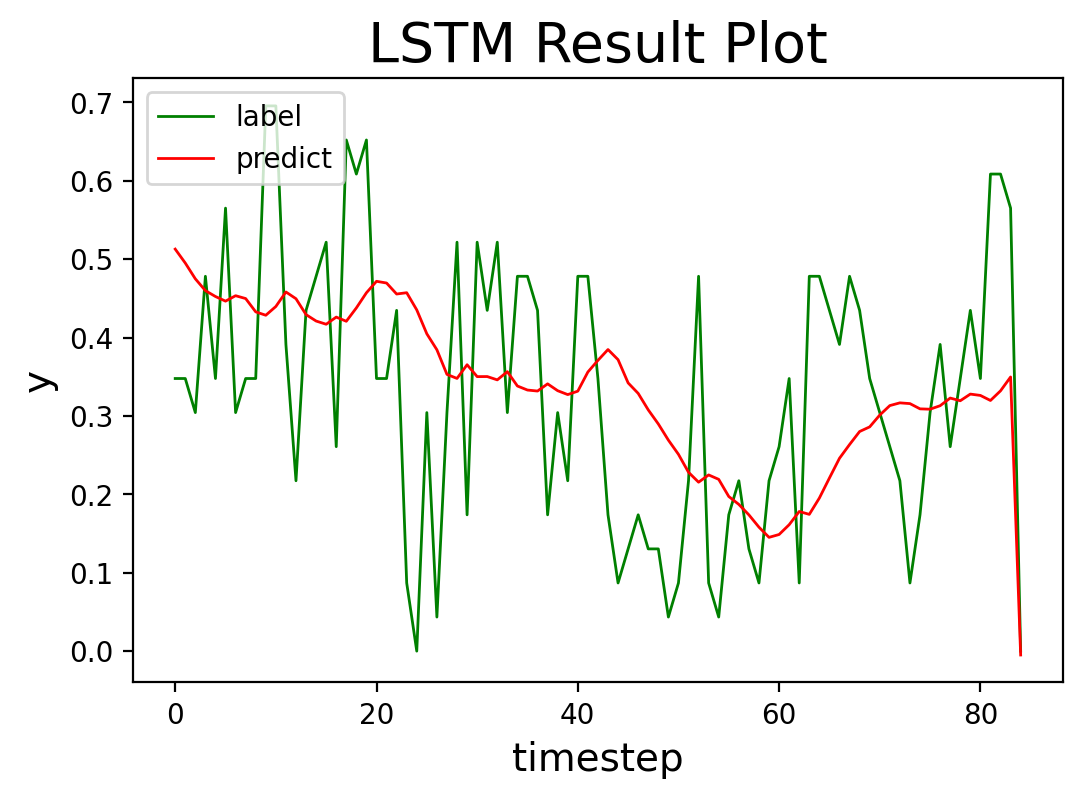

In [17]:
y_pre = model1.predict(X_test)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre,model_name='LSTM')

In [18]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = rmsprop_v2.RMSprop(lr=config['lr'])
model2.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
hist = model2.fit(
    X_train, y_train,
    validation_data=(X_train,y_train),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])

[INFO] training model...
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


10/10 [==============================] - 9s 169ms/step - loss: 0.1812 - mse: 0.1812 - val_loss: 0.1764 - val_mse: 0.1764 - lr: 5.0000e-04
Epoch 2/300
10/10 [==============================] - 0s 32ms/step - loss: 0.1483 - mse: 0.1483 - val_loss: 0.1451 - val_mse: 0.1451 - lr: 5.0000e-04
Epoch 3/300
10/10 [==============================] - 0s 30ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1215 - val_mse: 0.1215 - lr: 5.0000e-04
Epoch 4/300
10/10 [==============================] - 0s 30ms/step - loss: 0.1198 - mse: 0.1198 - val_loss: 0.1046 - val_mse: 0.1046 - lr: 5.0000e-04
Epoch 5/300
10/10 [==============================] - 0s 32ms/step - loss: 0.1138 - mse: 0.1138 - val_loss: 0.0929 - val_mse: 0.0929 - lr: 5.0000e-04
Epoch 6/300
10/10 [==============================] - 0s 31ms/step - loss: 0.1082 - mse: 0.1082 - val_loss: 0.0827 - val_mse: 0.0827 - lr: 5.0000e-04
Epoch 7/300
10/10 [==============================] - 0s 33ms/step - loss: 0.1001 - mse: 0.1001 - val_loss: 0.0717 - v

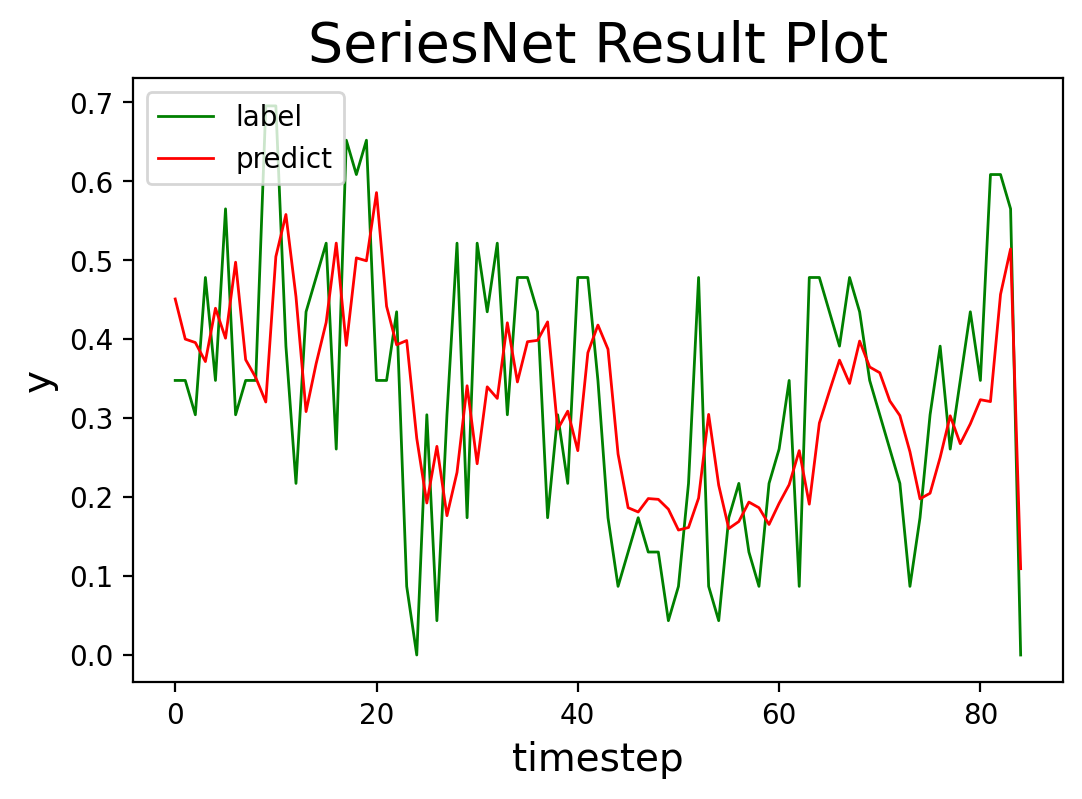

In [19]:
y_pre2 = model2.predict(X_test)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre2[:,config['seq_len']-1,:],model_name='SeriesNet')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


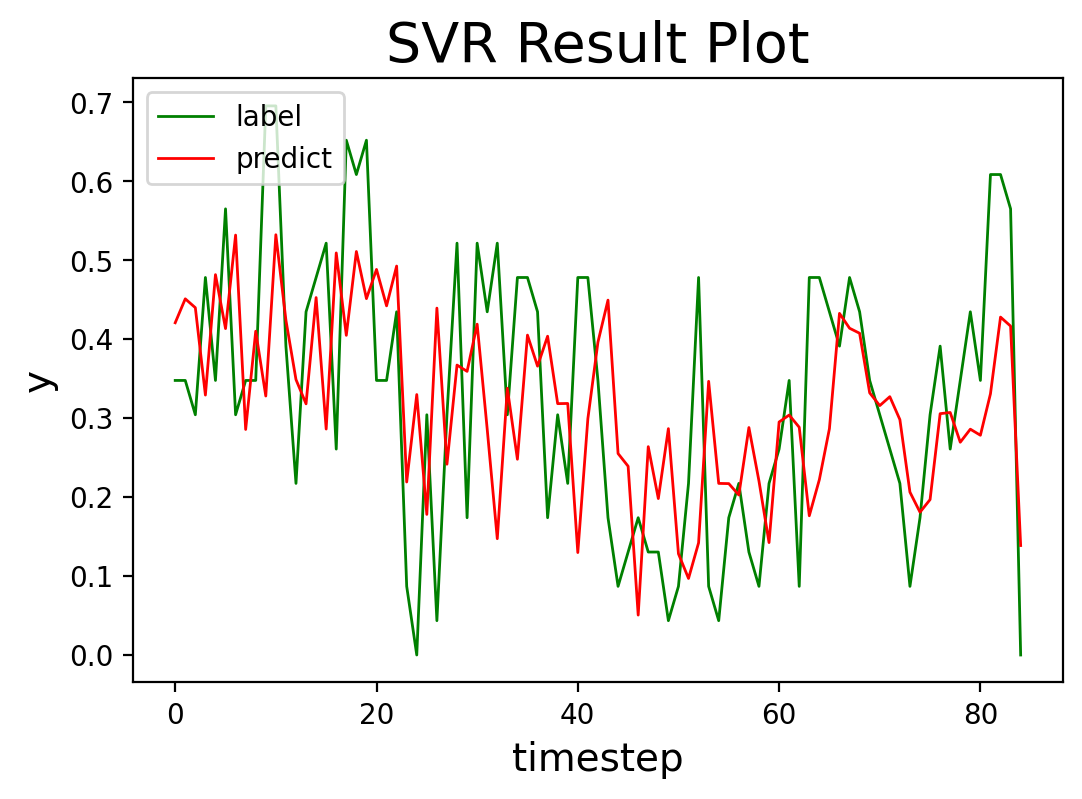

In [20]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train[:,:,0],y_train[:,config['seq_len']-1,:])
y_pre3 = svr_model.predict(X_test[:,:,0])
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre3,model_name='SVR')

In [21]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
def evaluate(y_true,y_pre):
  res_dict = dict()
  r2 = r2_score(y_true,y_pre)
  mae = mean_absolute_error(y_true,y_pre)
  rmse = np.sqrt(mean_squared_error(y_true,y_pre))
  res_dict['r2'] = r2
  res_dict['mae'] = mae
  res_dict['rmse'] = rmse
  print(res_dict)
  return res_dict

In [22]:
res_dict = evaluate(y_test[:,config['seq_len']-1,:],y_pre)
res_dict2 = evaluate(y_test[:,config['seq_len']-1,:],y_pre2[:,config['seq_len']-1,:])
res_dict3 = evaluate(y_test[:,config['seq_len']-1,:],y_pre3)

{'r2': 0.06444643325410915, 'mae': 0.1411640131717448, 'rmse': 0.16789087085466525}
{'r2': 0.21460345128876612, 'mae': 0.12873674241249516, 'rmse': 0.1538286563607932}
{'r2': 0.07101466277292257, 'mae': 0.13853165629809613, 'rmse': 0.16730047809370233}


In [23]:
print('LSTM-{}'.format(config['col']))
res_dict

LSTM-temp


{'mae': 0.1411640131717448,
 'r2': 0.06444643325410915,
 'rmse': 0.16789087085466525}

In [24]:
print('SeriesNet-{}'.format(config['col']))
res_dict2

SeriesNet-temp


{'mae': 0.12873674241249516,
 'r2': 0.21460345128876612,
 'rmse': 0.1538286563607932}

In [25]:
print('SVR-{}'.format(config['col']))
res_dict3

SVR-temp


{'mae': 0.13853165629809613,
 'r2': 0.07101466277292257,
 'rmse': 0.16730047809370233}

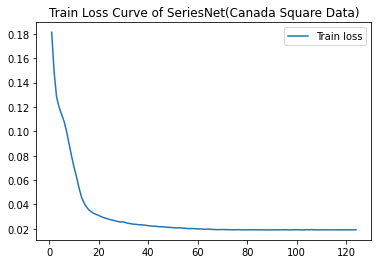

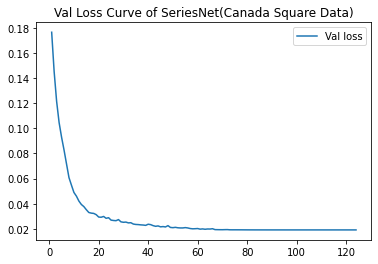

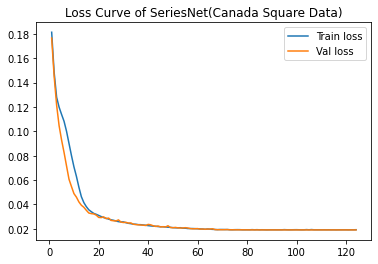

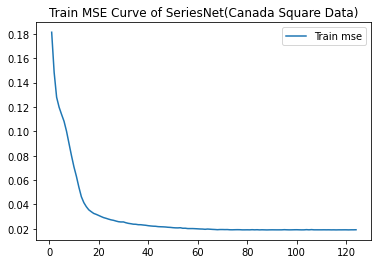

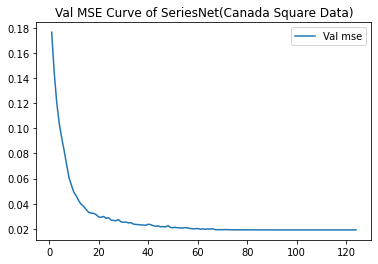

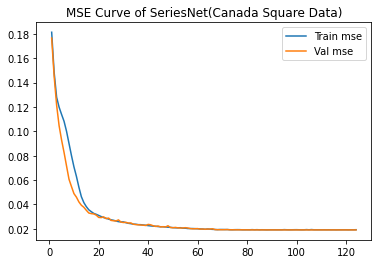

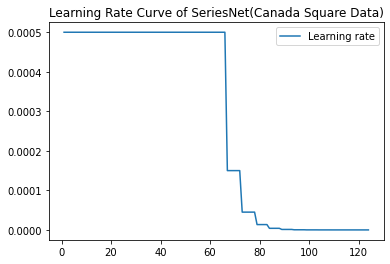

In [26]:
plot_all(hist, 'SeriesNet(Canada Square Data)')